# Basic CNN's with Keras

---
<b>Author</b>: Sterling Cutler
<br>
<b>Date</b>: 03/18/18
<br>
<b>Overview</b>: This notebook covers some features in working with Convolutional Neural Net (CNN) models in Keras. Certain parameters are set low for computational efficiency and demonstration purposes.

#### Setup

In [1]:
# Set filepath
import os
filepath = os.getcwd()
print(filepath)

/content


In [2]:
# Create directories for weights and logs
!mkdir weights
!mkdir tensorboard
!ls

datalab  tensorboard  weights


In [3]:
# Check GPU is running
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Part One
#### Sequential Model and Image Augmentation

In [4]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import History

Using TensorFlow backend.


In [0]:
# Define training parameters
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 10
RESNET_DEPTH = 20

In [0]:
# Track CIFAR 10 labels
labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 
          5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [7]:
# Load train/test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# One hot encode target labels
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
# Convert to float and normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.
x_test /= 255.

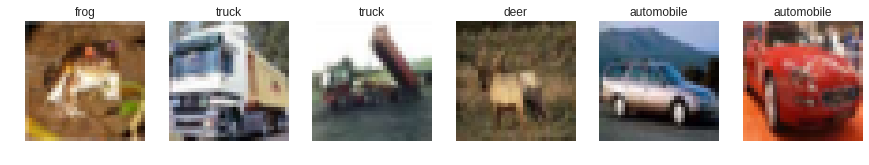

In [10]:
# Create sample images and show unaugmented
sample_images = x_train[:6]
sample_labels = y_train[:6]

fig, axes = plt.subplots(1, 6, squeeze=False, figsize=(15, 15))
for i in range(6):
  axes[0, i].axis('off')
  axes[0, i].set_title(labels[np.argmax(sample_labels[i])])
  axes[0, i].imshow(sample_images[i])

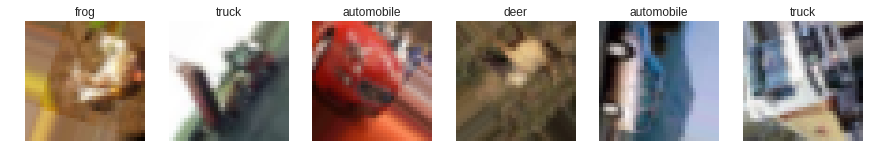

In [11]:
# Randomly shift, rotate, and flip images
srf_datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

for X_batch, y_batch in srf_datagen.flow(sample_images, 
                                         sample_labels, 
                                         batch_size=6):
  fig, axes = plt.subplots(1, 6, squeeze=False, figsize=(15, 15))
  for i in range(6):
    axes[0, i].axis('off')
    axes[0, i].set_title(labels[np.argmax(y_batch[i])])
    axes[0, i].imshow(X_batch[i])
  break

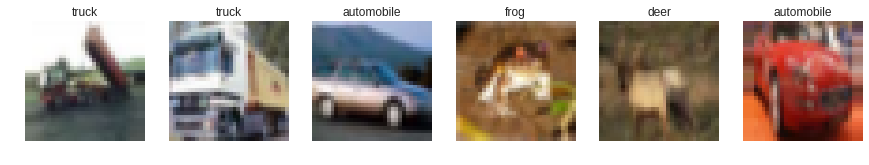

In [12]:
# Zoom in/out and shear images
zoom_datagen = ImageDataGenerator(
    zoom_range=[0.8, 1.2],
    shear_range=0.45)

for X_batch, y_batch in zoom_datagen.flow(sample_images, 
                                          sample_labels, 
                                          batch_size=6):
  fig, axes = plt.subplots(1, 6, squeeze=False, figsize=(15, 15))
  for i in range(6):
    axes[0, i].axis('off')
    axes[0, i].set_title(labels[np.argmax(y_batch[i])])
    axes[0, i].imshow(X_batch[i])
  break

In [0]:
# Define CNN model architecture
feature_layers = [
    Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]),
    Activation('relu'),
    Conv2D(32, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(512),
    Activation('relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES),
    Activation('softmax')
]

In [0]:
# Build and compile model
model = Sequential(feature_layers + classification_layers)

hist = History()
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [15]:
# Train CNN model with image augmentation
datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

model.fit_generator(datagen.flow(x_train, y_train, 
                        batch_size=BATCH_SIZE), 
                        epochs=EPOCHS,
                        validation_data=(x_test, y_test),
                        callbacks=[hist], 
                        verbose=0) # in practice, better to set at 1

print('Finished training')

Finished training


In [16]:
# Score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 172us/step
Test loss: 1.2112836296081544
Test accuracy: 0.5688


In [0]:
# Freeze feature layers and recompile
for l in feature_layers:
    l.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [18]:
# Continue training CNN model without image augmentation or validation set
model.fit(x_train, y_train, 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          callbacks=[hist], 
          verbose=0)

print('Finished training')

Finished training


In [19]:
# Score final model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 151us/step
Test loss: 1.0315796798706054
Test accuracy: 0.6412


## Part Two
#### Functional Model and Advanced Callbacks

In [0]:
# Import functional model and additional model features
from keras.models import Model
from keras.layers import Input, AveragePooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

In [0]:
# Define ResNet layer
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
# Define ResNet architecture 
#  - https://arxiv.org/pdf/1512.03385.pdf
def resnet(input_shape, depth, num_classes):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    
    # Start model definition
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            
            # Downsample on first layer of subsequent stacks
            if stack > 0 and res_block == 0:
                strides = 2
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            
            # Build and add model layers
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier head
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Build and return model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# Set learning rate schedule function
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 7:
        lr *= 0.5
    print('Learning rate: ', lr)
    return lr

In [24]:
# Compile model and show architecture
resnet_model = resnet(input_shape=(32, 32, 3), 
                      depth=RESNET_DEPTH, 
                      num_classes=NUM_CLASSES)

resnet_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

print(resnet_model.summary())

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
# Import and set callbacks
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

callbacks = [
    
    # saves best model weights based on validation loss
    ModelCheckpoint(filepath+'/weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                    monitor='val_loss',
                    save_best_only=True, 
                    save_weights_only=True),
    
    # writes log history to CSV file
    CSVLogger(filename=filepath+'/log.csv'),
    
    # changes learning rate based on epoch schedule
    LearningRateScheduler(lr_schedule),
    
    # reduces learning rate when validation loss stops improving
    ReduceLROnPlateau(factor=np.sqrt(0.1),
                      cooldown=0,
                      patience=5,
                      min_lr=0.5e-6),
    
    # https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard
    TensorBoard(log_dir=filepath+'/tensorboard/', 
                histogram_freq=0, 
                batch_size=32, 
                write_graph=True)
            
            ]

In [26]:
# Train ResNet model with callbacks and validation set
resnet_model.fit(x_train, y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=EPOCHS,
                 validation_data=(x_test, y_test),
                 callbacks=callbacks,
                 verbose=0)

print('Finished training')

Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.0005
Learning rate:  0.0005
Finished training


In [27]:
# Preview log file
# !head -3 log.csv

In [28]:
# Score trained model
scores = resnet_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 5s 509us/step
Test loss: 0.8432758609771729
Test accuracy: 0.7787
